In [91]:
import pandas as pd
from abc import abstractmethod
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import linear_model as lm
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
import torch.nn as nn
from torch import optim
from alibi.explainers import ALE
from alibi.explainers import plot_ale
import lime
from lime import lime_tabular
from tqdm import tqdm

In [54]:

class DataframePreparator:
    def __init__(self):
        self._df = None
        
        self._months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

        self._hours = [str(i) + ' AM' for i in range(1, 13)] + [str(i) + ' PM' for i in range(1, 13)]
        
        self._WEATHER_APPEARANCE = ['Any except rain', 'Any weather', 'Rain only']
        self._WEATHER_APPEARANCE_FISH = {'Yes': 'Any weather', 'No': 'Any except rain'}

        self._COLOR_TONES = {
            'Cold': ('Blue', 'Light Blue', 'Purple', 'Green'),
            'Neutral': ('Black', 'Beige', 'Gray', 'White'),
            'Warm': ('Brown', 'Orange', 'Red', 'Pink', 'Yellow')
        }
        
        self._UNWANTED_COLUMNS = [f'SH {month}' for month in self._months] + [
            'Unique Entry ID', 'Internal ID', 'Critterpedia Filename',
            'Furniture Filename', 'Icon Filename', 'Name', '#'
        ]
        
        self._SEASONS = {
            'Spring': ['NH ' + self._months[i] for i in range(0,3)],
            'Summer': ['NH ' + self._months[i] for i in range(3,6)],
            'Autumn': ['NH ' + self._months[i] for i in range(6,9)],
            'Winter': ['NH ' + self._months[i] for i in range(9,12)]
        }
        
        self._TIMESTAMPS = {
            'Midnight': ([self._hours[-1]]+ self._hours[0:3]),
            'Sunrise': (self._hours[3:7]),
            'Morning': (self._hours[7:11]),
            'Midday': (self._hours[11:15]),
            'Afternoon': (self._hours[15:19]),
            'Evening': (self._hours[19:23])
        }
        
        self._WHERE_HOW_CORRESPONDENCE_PF = './data/where_how_correspondence.csv'
        
    
    # Método privado para establecer el dataframe
    def _set_df(self, df: pd.DataFrame | None = None, df_path: str | None = None, is_fish: bool = False):
        # Verificamos que se haya enviado un dataframe
        if df is None and df_path is None:
            raise ValueError('Either df or df_path must be defined')
        
        # Si no mandaron el dataframe en raw, lo leemos del path
        if df is None:
            self._df = pd.read_csv(df_path)
        else:
            self._df = df
            
        # Eliminamos columnas no deseadas y específicas si es un pez
        columns_to_drop = self._UNWANTED_COLUMNS + (['Size', 'Shadow', 'Lighting Type'] if is_fish else [])
        
        # Establecemos el dataframe de la clase al mismo
        self._df = self._df.drop(columns=columns_to_drop)
    
    
    # Método para el procesamiento
    def process(self, df: pd.DataFrame | None = None, df_path: str | None = None, is_fish: bool = False) -> pd.DataFrame:
        # Establecemos el df
        self._set_df(df=df, df_path=df_path, is_fish=is_fish)
        
        # Procesamos
        self._process_months()
        self._process_colors()
        self._process_weather(is_fish)
        self._process_where_how()
        self._process_spawn_rate()
        
        # Devolvemos el nuevo dataframe
        return self._df
    
    # Método privado para el procesamiento de los meses
    def _process_months(self):        
        # Selecciona las columnas de meses
        monthly_columns = self._df.loc[:, 'NH Jan':'NH Dec']

        # Si no hay columnas o han sido borradas, no procesamos el dataframe
        if monthly_columns is None:
            return 
        
        self._process_seasons(monthly_columns)
        self._process_timestamps(monthly_columns)

        self._df = self._df.drop(columns=monthly_columns)
  

    # Método privado para el procesamiento de las estaciones
    def _process_seasons(self, monthly_columns):
        # Inicializa columnas de temporadas en el DataFrame
        for season in self._SEASONS:
            self._df[season] = 0

        # Miramos todas las columnas en el df
        for index, row in monthly_columns.iterrows():
            # Almacenamos la cuenta de la aparición de cada estación en base a los meses
            season_counts = {season: 0 for season in self._SEASONS}

            for col in monthly_columns.columns:
                value = row[col]
                
                # En caso de que la columna no contenga ningún valor, pasamos de ella
                if not pd.notna(value):
                    continue
                
                # Si no, hacemos la cuenta
                for season, season_values in self._SEASONS.items():
                    if col in season_values:
                        season_counts[season] += 1

            # Si hay al menos 2 meses activos para una temporada, marca con 1
            for season in self._SEASONS:
                if season_counts[season] >= 2:
                    self._df.at[index, season] = 1
    
    # Método privado para el procesamiento de las horas         
    def _process_timestamps(self, monthly_columns):
        # Inicializa columnas de temporadas en el DataFrame
        for timestamp in self._TIMESTAMPS:
            self._df[timestamp] = 0

        # Miramos todas las columnas en el df
        for index, row in monthly_columns.iterrows():
            # Almacenamos la cuenta de la aparición de cada estación en base a los meses
            timestamp_counts = {timestamp: 0 for timestamp in self._TIMESTAMPS}

            for col in monthly_columns.columns:
                value = row[col]

                # En caso de que la columna no contenga ningún valor, pasamos de ella
                if not pd.notna(value):
                    continue
                
                # Ponemos el valor máximo en caso de que se marque all day a todos los timestamps
                if value.lower() == 'all day':
                    for timestamp in self._TIMESTAMPS:
                        timestamp_counts[timestamp] = 4 
                    continue
                
                # Si no, primero sacamos un array que contenga todas las horas entre las franjas
                check_twice = value.split(';')
                
                values = []
                
                for i in range(len(check_twice)):
                    cleaned_value = check_twice[i].replace('\xa0', ' ').replace('–', '-').strip()
                    split_value = cleaned_value.split(' - ')
                    initial_value = self._hours.index(split_value[0])
                    hours = self._hours[initial_value:] + self._hours[:initial_value]
                    initial_value = 0
                    final_value = hours.index(split_value[1])
                    values  += hours[initial_value:final_value]                

                # Y calculamos
                for timestamp, timestamp_values in self._TIMESTAMPS.items():
                    for val in values:
                        if val in timestamp_values:
                            timestamp_counts[timestamp] += 1
            # Si hay al menos 2 horas activos para una timestamp, marca con 1
            for timestamp in self._TIMESTAMPS:
                if timestamp_counts[timestamp] >= 2:
                    self._df.at[index, timestamp] = 1
    
    # Método privado para el procesamiento de los colores
    def _process_colors(self):
        # Creamos las columnas con valores iniciales de 0
        self._df[[tone for tone in self._COLOR_TONES]] = 0
        
        for index, row in self._df.iterrows():
            # Extraemos los colores de la fila
            colors_row = [row['Color 1'], row['Color 2']]
            
            # Iteramos sobre los tonos y valores asociados
            for tone, tone_values in self._COLOR_TONES.items():
                # Comprobamos cuántos colores coinciden con los valores de cada tono
                for color in colors_row:
                    if color in tone_values:
                        self._df.at[index, tone] += 1
        
        # Eliminamos las columnas de Color 1 y Color 2
        self._df = self._df.drop(columns=['Color 1', 'Color 2'])

    
    # Método privado para el procesamiento del atributo weather
    def _process_weather(self, is_fish:bool):
        # Creamos las columnas con valores iniciales de 0
        self._df[[weather for weather in self._WEATHER_APPEARANCE]] = 0
        
        # El nombre y procesamiento de la columna varía si es pez o no
        if not is_fish:
            for index, row in self._df.iterrows():
                # Iteramos por las opciones de clima
                for weather in self._WEATHER_APPEARANCE:
                    # Si el weather de esa fila se corresponde con el de la iteración le ponemos el valor a 1 y pasamos al siguiente
                    if row['Weather'] == weather:
                        self._df.at[index, weather] = 1
                        continue
                    
            # Eliminamos la columna Weather de la tabla
            self._df = self._df.drop(columns=['Weather'])
        
        # Hacemos la casuística para los peces
        else:
            for index, row in self._df.iterrows():
                # Iteramos por las opciones de clima de pez
                for weather, weather_values in self._WEATHER_APPEARANCE_FISH.items():
                    # Si el weather de esa fila se corresponde con el de la iteración le ponemos el valor a 1 y pasamos al siguiente
                    if row['Rain/Snow Catch Up'] == weather:
                        self._df.at[index, weather_values] = 1
                        continue
                    
            # Eliminamos la columna Weather de la tabla
            self._df = self._df.drop(columns=['Rain/Snow Catch Up'])
    
    def _process_where_how(self):
        # Creamos la columna vacía
        self._df[['Appearance Location']] = 0
        
        # Así como un diccionario donde almacenar los datos leídos del archivo
        where_how_dict = {}
        
        # Probamos a leer el archivo y nos mantenemos al loro por si ocurriera un error
        try:
            # Abre el archivo CSV
            with open(self._WHERE_HOW_CORRESPONDENCE_PF, 'r') as lines:
                for line in lines:
                    # Separa la línea por puntos y comas y quita saltos de línea
                    line_value = line.strip().split(';')
                    
                    # Comprobamos que no haya un error de formato en el texto (más de un ;)
                    if len(line_value) > 2:
                        raise ValueError(f"Error de formato en la linea {line_value} a la hora de procesar la información de Where/How")
                    
                    # El primer valor será la clave y el segundo el valor
                    key = line_value[0]  
                    value = line_value[1] 

                    # Añadir la clave y el valor al diccionario
                    where_how_dict[key] = value

        # De ocurrir un error, lanzamos otro con un mensaje custom indicando la raíz del error
        except FileNotFoundError:
            raise ValueError('File corresponding to where how information not found on ./data/')

        # Iteramos por las líneas del dataframe
        for index, row in self._df.iterrows():
            # Ingresamos los valores según las columnas
            self._df.at[index, 'Appearance Location'] = int(where_how_dict[row['Where/How']])
        
        # Eliminamos el atributo where/how
        self._df = self._df.drop(columns=['Where/How'])
    
    def _process_spawn_rate(self):
        
        # Iteramos por las líneas del dataframe
        for index, row in self._df.iterrows():
            # Dividimos la variable de ser posible
            values = row['Spawn Rates'].split('–')
            # Si hay más de un valor hacemos la media y la asignamos
            if len(values) > 1:
                numbers = [int(value.strip()) for value in values]
                average = sum(numbers) / len(numbers)
                self._df.at[index, 'Spawn Rates'] = int(average)

    # Método para obtener el dataframe
    def get_df(self):
        return self._df
    
    # Método que une dataframes
    def join_dataframe(self, df:pd.DataFrame):
        return pd.concat([self._df, df], ignore_index=True)


df_prep = DataframePreparator()

insects_dataframe = df_prep.process(df_path='./data/insects.csv', is_fish=False)
fish_dataframe = df_prep.process(df_path='./data/fish.csv', is_fish=True)
dataframe = df_prep.join_dataframe(insects_dataframe)
dataframe


,Sell,Total Catches to Unlock,Spawn Rates,Spring,Summer,Autumn,Winter,Midnight,Sunrise,Morning,Midday,Afternoon,Evening,Cold,Neutral,Warm,Any except rain,Any weather,Rain only,Appearance Location
0,200,0,3,1,1,1,1,0,1,1,1,1,1,1,0,1,1,0,0,6
1,3000,20,3,0,1,1,0,1,1,1,0,1,1,0,1,1,1,0,0,5
2,10000,50,1,0,0,1,0,1,1,1,0,1,1,1,1,0,0,1,0,5
3,10000,50,1,0,0,1,0,1,1,1,0,1,1,0,1,1,1,0,0,5
4,5000,20,4,0,1,1,1,1,1,1,1,1,1,0,2,0,1,0,0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,600,20,10,0,0,1,0,1,1,1,1,1,1,2,0,0,0,1,0,10
156,600,20,10,0,0,1,1,0,1,0,0,1,0,0,0,2,0,1,0,10
157,2500,0,0,1,1,1,1,1,1,1,1,1,1,0,0,2,0,1,0,10
158,200,0,20,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,0,3


---
Comenzamos con los modelos de IA Clásica

In [55]:
class RegressionModels:
    def __init__(self):
        self._data = None
        self._train_data = None
        self._test_data = None
        self._train_results = None
        self._test_results = None
        self._model = None
    
    # Método que se encarga de verificar que el dataframe proporcionado es un dataframe y no está vacío
    def _verify_data(self, data:pd.DataFrame) -> None:
        # Verificamos que se trate de un dataframe no nulo
        if not isinstance(data, pd.DataFrame) or data.empty: 
            raise ValueError("No valid DataFrame provided")
        
        # Hacemos la asignación 
        self._data = data
    
    # Método que normaliza los datos, salvo el precio
    def _normalize_data(self) -> None:
        # Definimos el normalizador habitual (MinMaxScaler)
        min_max_scaler = preprocessing.MinMaxScaler()
        
        # Guardamos la columna de Sell
        sell_column = self._data['Sell'].copy()
        
        # Guardamos el nombre de las columnas
        column_names = self._data.columns
        
        # Normalizamos los datos y los reconvertimos a DataFrame manteniendo el nombre de las columnas
        normalized_data = pd.DataFrame(
            min_max_scaler.fit_transform(self._data),
            columns=column_names
        )
        
        # Modificamos el valor de la columna Sell para que tenga los valores sin normalizar
        normalized_data['Sell'] = sell_column
        
        # Reescribimos la variable Data
        self._data = normalized_data[self._data.columns]
    
    # Método privado para la preparación de los datos
    def _prepare_data(self, test_size:float = 0.2) -> None:
        # Normalizamos los datos
        self._normalize_data()
        
        # Preparamos el sample de test y de train
        self._train_data, self._test_data = train_test_split(self._data, test_size=test_size, random_state=22)
        
        # Aislamos la columna a predecir (Precio)
        self._train_results = self._train_data[['Sell']]
        self._test_results = self._test_data[['Sell']]
        
        # Eliminamos la columna a predecir (Precio)
        self._train_data = self._train_data.drop(columns=['Sell'])
        self._test_data = self._test_data.drop(columns=['Sell'])
        
        # Nos aseguramos de que todas las columnas tienen el título en texto
        self._train_data.columns = self._train_data.columns.astype(str)
        self._train_results.columns = self._train_results.columns.astype(str)
        self._test_data.columns = self._test_data.columns.astype(str)
        self._test_results.columns = self._test_results.columns.astype(str)

        
    # Método abstracto y privado donde se especifica la implementación según la extensión    
    @abstractmethod
    def _regression(self) -> None:
        pass        
    
    # Método privado que obtiene la precisión en base al modelo usado
    def get_precision(self):
        _test_predictions = self._model.predict(self._test_data)

        test_r2 = r2_score(self._test_results, _test_predictions)
    
        # MSE (Mean Squared Error) → Cuanto más bajo, mejor
        test_mse = mean_squared_error(self._test_results, _test_predictions)
        
        # MAE (Mean Absolute Error) → Cuanto más bajo, mejor
        test_mae = mean_absolute_error(self._test_results, _test_predictions)
        
        return test_r2 * 100, test_mse, test_mae
    
    # Método público que realiza todos los cálculos
    def compute(self, data:pd.DataFrame) -> float:
        self._verify_data(data)
        self._prepare_data()
        self._regression()
        return self.get_precision()
    
    # Método público y abstracto encargado de hacer el plot del último dataframe o si no de uno nuevo
    @abstractmethod
    def show_plot(self, data:pd.DataFrame | None = None):
        pass
        
        
# Particularización de la clase regression_models para el modelo de regresión linear
class LinearRegression(RegressionModels):
    
    # Implementación del método de regresión
    def _regression(self) -> None:
        # Creamos el regressor
        lin_reg = lm.LinearRegression()
        # Lo entrenamos
        lin_reg.fit(self._train_data, self._train_results)
        # Lo establecemos como modelo de la clase
        self._model = lin_reg
    
    # Implementación del método plot
    def show_plot(self, data: pd.DataFrame | None = None):
        # Verificamos que se trabaje sobre un dataset viejo o no
        if data is not None:
            self.compute(data)
        
        # Predicciones sobre el test set        
        test_pred = self._model.predict(self._test_data).ravel()
        test_actual = self._test_results['Sell'].values.ravel()

        # Gráfica
        plt.scatter(test_actual, test_pred, color='blue', label='Valores reales')
        plt.plot([test_actual.min(), test_actual.max()], 
                 [test_actual.min(), test_actual.max()], 
                 'r--' ,label='Regresión Lineal')
        plt.title('Regresión Lineal - Valores reales vs Predichos')
        plt.xlabel('Valor Sell Real')
        plt.ylabel('Valo Sell Predicho')
        plt.legend()
        plt.grid(True)
        plt.show()


# Particularización de la clase regression_models para el modelo de regresión polinomial        
class PolynomialRegression(RegressionModels):
    
    # Constructor de la clase específico
    def __init__(self, degree:int=2):
        # Mandamos los datos a la clase madre
        super().__init__()
        # Definimos atributos propios
        self._degree = degree
        
    # Implementación del método de regresión
    def _regression(self)-> None:
        # Definimos un transformador para operar con polinomios
        self._poly_features = preprocessing.PolynomialFeatures(self._degree)
        
        # Transformar los datos
        self._train_data = self._poly_features.fit_transform(self._train_data)
        self._test_data = self._poly_features.transform(self._test_data)
        
        # Usar regresión ridge para evitar overfitting (Basada en mínimos cuadrados)
        pol_reg = lm.Ridge(alpha=1.0)
        # Entrenamos el modelo
        pol_reg.fit(self._train_data, self._train_results)
        
        # Definimos el modelo de la clase para predicciones
        self._model = pol_reg
        
    # Implementación del método de plot
    def show_plot(self, data: pd.DataFrame | None = None):
        # Verificamos que se trabaje sobre datos viejos
        if data is not None:
            self.compute(data)

        # Cogemos el valor de los resultados y lo transformamos a numpy
        x_plot = self._test_results.iloc[:, 0].values
        
        # Hacemos una predicción en base al modelo
        y_test_pred = self._model.predict(self._test_data).ravel()

        # Ordenamos los datos
        sort_idx = np.argsort(x_plot)
        x_sorted = x_plot[sort_idx]
        y_pred_sorted = y_test_pred[sort_idx]
        

        # Gráfica
        plt.scatter(x_sorted, y_pred_sorted, color='blue', label='Valores reales')
        plt.title(f'Regresión Polinómica - Grado {self._degree}')
        plt.xlabel('Valor Sell Real')
        plt.ylabel('Valor Sell Predicho')
        plt.legend()
        plt.grid(True)
        plt.show()


_____________

Una vez creadas las clases podemos proceder al muestreo de datos:


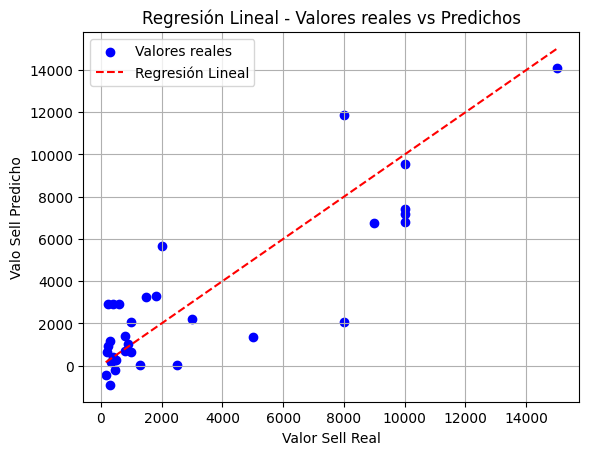

Precision: 72.92%
Error cuadrático medio: 4584255.64
Error absoluto medio: 1623.01




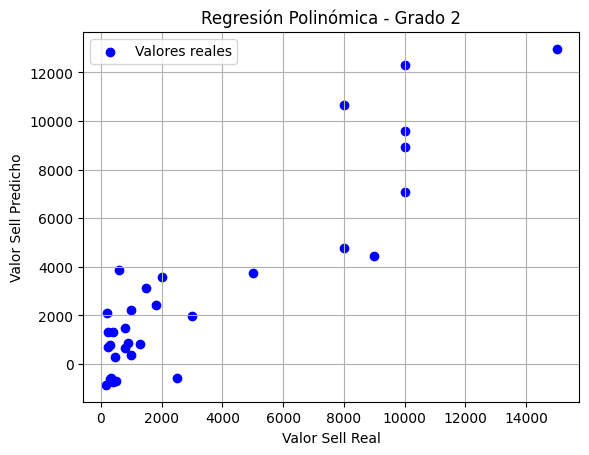

Precision: 81.46%
Error cuadrático medio: 3138388.23
Error absoluto medio: 1408.91





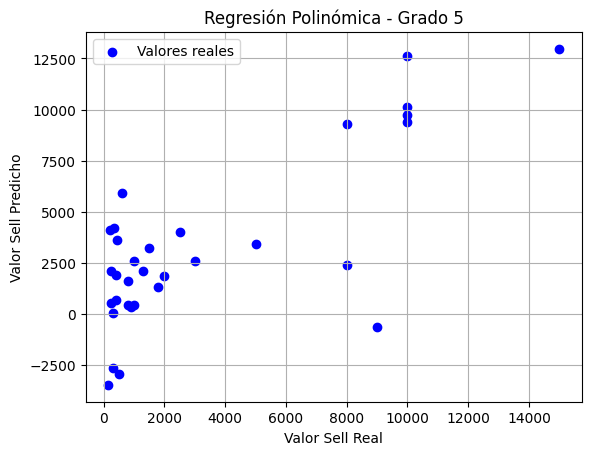

Precision: 52.45%
Error cuadrático medio: 8048987.67
Error absoluto medio: 1971.50




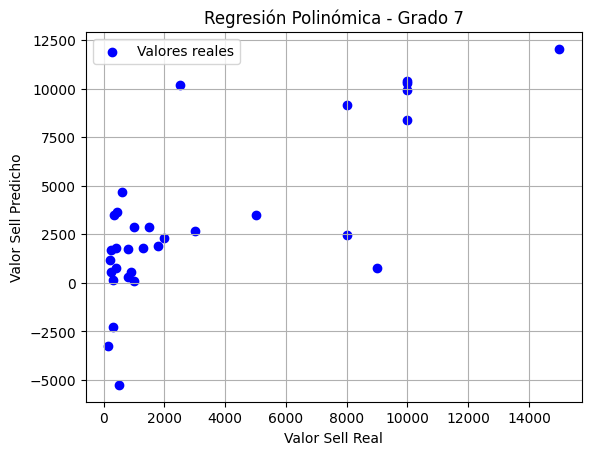

Precision: 49.24%
Error cuadrático medio: 8591592.02
Error absoluto medio: 1986.00
******************************************************************

=============== Regresión Lineal ===============
Precisión media: 72.92%
Error absoluto medio: 1623.01u
Tiempo tomado: 0.77s


=============== Regresión Polinomial (2) ===============
Precisión media: 81.46%
Error absoluto medio: 1408.91u
Tiempo tomado: 2.76s


=============== Regresión Polinomial (5) ===============
Precisión media: 52.45%
Error absoluto medio: 1971.50u
Tiempo tomado: 10.09s


=============== Regresión Polinomial (7) ===============
Precisión media: 49.24%
Error absoluto medio: 1986.00u
Tiempo tomado: 69.75s




In [56]:
def compute_avg_values(n:int, reg_model:RegressionModels):
    avg_total = []
    mae_total = []

    t0 = time.time()
    for i in range(n):
        total = reg_model.compute(dataframe)
        avg_total.append(total[0])
        mae_total.append(total[2])
    t1 = time.time()

    reg_avg = sum(avg_total)/len(avg_total)
    reg_mae = sum(mae_total)/len(mae_total)

    return reg_avg, reg_mae, t1-t0


# Uso de los diferentes modelos

# Modelo de regresión lineal
lin_model = LinearRegression()
res = lin_model.compute(dataframe)
lin_model.show_plot()
print("=================================================")
print(f"Precision: {res[0]:.2f}%")
print(f"Error cuadrático medio: {res[1]:.2f}")
print(f"Error absoluto medio: {res[2]:.2f}")
print("\n")

# Modelos de regresión polinomial
pol_model = PolynomialRegression(2)
res = pol_model.compute(dataframe)
pol_model.show_plot()
print("=================================================")
print(f"Precision: {res[0]:.2f}%")
print(f"Error cuadrático medio: {res[1]:.2f}")
print(f"Error absoluto medio: {res[2]:.2f}")
print("\n\n")

pol_model = PolynomialRegression(5)
res = pol_model.compute(dataframe)
pol_model.show_plot()
print("=================================================")
print(f"Precision: {res[0]:.2f}%")
print(f"Error cuadrático medio: {res[1]:.2f}")
print(f"Error absoluto medio: {res[2]:.2f}")
print("\n")

pol_model = PolynomialRegression(7)
res = pol_model.compute(dataframe)
pol_model.show_plot()
print("=================================================")
print(f"Precision: {res[0]:.2f}%")
print(f"Error cuadrático medio: {res[1]:.2f}")
print(f"Error absoluto medio: {res[2]:.2f}")
print("******************************************************************\n")


print("=============== Regresión Lineal ===============")
lin_model = LinearRegression()
avg, mae, t = compute_avg_values(100, lin_model)
print(f"Precisión media: {avg:.2f}%")
print(f"Error absoluto medio: {mae:.2f}u")
print(f"Tiempo tomado: {t:.2f}s")
print("\n")

print("=============== Regresión Polinomial (2) ===============")
pol_model = PolynomialRegression(2)
avg, mae, t = compute_avg_values(100, pol_model)
print(f"Precisión media: {avg:.2f}%")
print(f"Error absoluto medio: {mae:.2f}u")
print(f"Tiempo tomado: {t:.2f}s")
print("\n")

print("=============== Regresión Polinomial (5) ===============")
pol_model = PolynomialRegression(5)
avg, mae, t = compute_avg_values(100, pol_model)
print(f"Precisión media: {avg:.2f}%")
print(f"Error absoluto medio: {mae:.2f}u")
print(f"Tiempo tomado: {t:.2f}s")
print("\n")

print("=============== Regresión Polinomial (7) ===============")
pol_model = PolynomialRegression(7)
avg, mae, t = compute_avg_values(100, pol_model,)
print(f"Precisión media: {avg:.2f}%")
print(f"Error absoluto medio: {mae:.2f}u")
print(f"Tiempo tomado: {t:.2f}s")
print("\n")



---
Comenzamos con los modelos de IA Modernos

FNN:

In [57]:
class FeedforwardNeuralNetModel(nn.Module):
    def __init__(self, df: pd.DataFrame, epochs=500, using_relu:bool=False, dropout:float=0.1):
        super().__init__()
        self._data = df
        self._epochs = epochs
        self._criterion = nn.MSELoss()

        # Configuración de hiperparámetros
        self.hidden_dim = 128
        self.dropout_prob = dropout
        self.learning_rate = 0.001
        self._using_relu = using_relu

        self._prepare_data()
        self._create_layers()
        self._optimizer = optim.Adam(self.parameters(), lr=self.learning_rate)

    def _prepare_data(self, test_size: float = 0.2):
        # Usar RobustScaler para mejor manejo de outliers
        self.scaler = preprocessing.RobustScaler()
        scaled_data = self.scaler.fit_transform(self._data)
        self._data = pd.DataFrame(scaled_data, columns=self._data.columns)

        # Split
        train, test = train_test_split(self._data, test_size=test_size, random_state=22)

        # Convertir a tensores
        self.X_train = torch.FloatTensor(train.drop('Sell', axis=1).values)
        self.y_train = torch.FloatTensor(train['Sell'].values).view(-1, 1)
        self.X_test = torch.FloatTensor(test.drop('Sell', axis=1).values)
        self.y_test = torch.FloatTensor(test['Sell'].values).view(-1, 1)

    def _create_layers(self):
        input_dim = self.X_train.shape[1]

        # Selección de función de activación basada en using_relu
        activation = nn.ReLU() if self._using_relu else nn.LeakyReLU(0.01)

        # Construcción dinámica de capas
        layers = [nn.Linear(input_dim, self.hidden_dim), activation]

        # Primera capa oculta
        if self.dropout_prob > 0:
            layers.append(nn.Dropout(self.dropout_prob))

        # Segunda capa oculta
        layers.append(nn.Linear(self.hidden_dim, self.hidden_dim))
        layers.append(activation)
        if self.dropout_prob > 0:
            # Menor dropout en capas más profundas
            layers.append(nn.Dropout(self.dropout_prob/2))

        # Capa de salida
        layers.append(nn.Linear(self.hidden_dim, 1))

        self.network = nn.Sequential(*layers)

        # Inicialización de pesos adaptada a la función de activación
        self._initialize_weights()

    # Método privado de inicialización de los pesos mediante kaiming normal
    def _initialize_weights(self):
        # Por cada una de las capas
        for m in self.modules():
            # Si no es capa de activación
            if isinstance(m, nn.Linear):
                # Define el modelo
                if self._using_relu:
                    nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
                else:
                    nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='leaky_relu')

    def forward(self, x):
        # Devuelve el elemento "x" después de ser procesado por la red definida
        return self.network(x)

    def fit(self, show_info:bool=True):
        # Método de la clase madre
        self.train()
        # Por cada uno de los epochs
        for epoch in range(self._epochs):
            # Optimizamos
            self._optimizer.zero_grad()
            # Hacemos el Forward
            outputs = self(self.X_train)
            # Sacamos la pérdida
            loss = self._criterion(outputs, self.y_train)
            # Hacemos el backward sobre la misma
            loss.backward()

            # Gradient clipping para estabilidad
            torch.nn.utils.clip_grad_norm_(self.parameters(), 1.0)

            # Actualiza los parámetros del algoritmo en base al regresor
            self._optimizer.step()

            # Si queremos mostrar la salida, lo haremos una vez por cada 50 epochs
            if (epoch+1) % 50 == 0 and show_info:
                print(f'Epoch {epoch+1}, Loss: {loss.item():.6f}')

    def evaluate(self, show_info:bool=True):
        # Método de la clase madre
        self.eval()
        # "Importamos" no_grad de torch
        with torch.no_grad():
            # Sacamos el forward de la predicción
            pred = self(self.X_test)
            # Así como la pérdida
            # self._criterion(pred, self.y_test)

            # Convertir a escala original
            test_data = np.concatenate([self.X_test.numpy(), self.y_test.numpy()], axis=1)
            pred_data = np.concatenate([self.X_test.numpy(), pred.numpy()], axis=1)
            y_true = self.scaler.inverse_transform(test_data)[:, -1]
            y_pred = self.scaler.inverse_transform(pred_data)[:, -1]

            # Cálculo de métricas
            fnn_mse = mean_squared_error(y_true, y_pred)
            fnn_mae = mean_absolute_error(y_true, y_pred)
            fnn_r2 = r2_score(y_true, y_pred)
            relative_error = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-10))) * 100
            median_error = np.median(np.abs((y_true - y_pred) / (y_true + 1e-10))) * 100

            if show_info:
                print(f'\n=== Métricas Finales ===')
                print(f'- MSE: {fnn_mse:.4f}')
                print(f'- MAE: {fnn_mae:.4f}')
                print(f'- R²: {fnn_r2:.4f}')
                print(f'- Precisión Media: {100 - relative_error:.2f}%')
                print(f'- Precisión Mediana: {100 - median_error:.2f}%')
                print(f'- Función Activación: {"ReLU" if self._using_relu else "LeakyReLU"}')
                print(f'- Dropout: {self.dropout_prob}')

            return y_pred, 100 - relative_error, 100 - median_error





Realizamos las pruebas del FNN


In [58]:
# Pruebas comparativas
configs = [
    {"using_relu": False, "dropout": 0.0, "name": "LeakyReLU, sin Dropout"},
    {"using_relu": False, "dropout": 0.1, "name": "LeakyReLU, con Dropout"},
    {"using_relu": True, "dropout": 0.0, "name": "ReLU, sin Dropout"},
    {"using_relu": True, "dropout": 0.1, "name": "ReLU, con Dropout"}
]

evaluations = {}

model_results = {}

results = {
    "top_models": [],
    "bottom_models": [],
}

for config in configs:
    model_results[config["name"]] = -1

# Ejecutar el proceso 250 veces
for iteration in tqdm(range(250), desc="Progreso general", unit="iter"):
    for config in configs:
        model = FeedforwardNeuralNetModel(
            df=dataframe,
            epochs=500,
            using_relu=config['using_relu'],
            dropout=config['dropout']
        )
        model.fit(show_info=False)
        predictions, mean_precision, median_precision = model.evaluate(show_info=False)

        evaluations[config['name']] = mean_precision


    top_model = ['', 0]
    bot_model = ['', 100]

    for model, mean in evaluations.items():
        last_value = model_results[model]
        if last_value == -1:
            model_results[model] = mean
        else:
            avg = (last_value + mean)/2
            model_results[model] = avg

        if mean > top_model[1]:
            top_model = [model, mean]

        if mean < bot_model[1]:
            bot_model = [model, mean]

    results["top_models"].append(top_model[0])
    results["bottom_models"].append(bot_model[0])


# Calculamos estadísticas para todos los modelos
top_counts = {model: results['top_models'].count(model) for model in model_results.keys()}
bot_counts = {model: results['bottom_models'].count(model) for model in model_results.keys()}

# Mostrar resultados finales para todos los modelos ordenados
print("\n\n============== RESULTADOS FINALES (250 iteraciones) ==============\n")
sorted_models = sorted(model_results.items(), key=lambda x: x[1], reverse=True)

counter = 1
for model, mean in sorted_models:
    print(f"\t{counter}. {model}: Precisión media {mean:.2f}% "
          f"(Veces primero: {top_counts[model]}, Veces último: {bot_counts[model]})")
    counter += 1

Progreso general: 100%|██████████| 250/250 [15:40<00:00,  3.76s/iter]



============== RESULTADOS FINALES (250 iteraciones) ==============

	1. LeakyReLU, con Dropout: Precisión media 86.83% (Veces primero: 129, Veces último: 0)
	2. ReLU, con Dropout: Precisión media 86.15% (Veces primero: 120, Veces último: 0)
	3. ReLU, sin Dropout: Precisión media 81.02% (Veces primero: 0, Veces último: 124)
	4. LeakyReLU, sin Dropout: Precisión media 80.52% (Veces primero: 1, Veces último: 126)


---
Pasamos al segundo modelo de IA Moderno, el LSTM


In [59]:
class LSTMModel(nn.Module):
    def __init__(self, df: pd.DataFrame, epochs=500, using_relu:bool=False, dropout:float=0.1):
        super().__init__()
        self._data = df
        self._epochs = epochs
        self._criterion = nn.MSELoss()

        # Configuración de hiperparámetros LSTM
        self.hidden_dim = 128
        # Número de capas LSTM apiladas
        self.num_layers = 2
        self.dropout_prob = dropout
        self.learning_rate = 0.001
        self._using_relu = using_relu

        self._prepare_data()
        self._create_layers()
        self._optimizer = optim.Adam(self.parameters(), lr=self.learning_rate)

    def _prepare_data(self, test_size: float = 0.2):
        # Usar RobustScaler para mejor manejo de outliers
        self.scaler = preprocessing.RobustScaler()
        scaled_data = self.scaler.fit_transform(self._data)
        self._data = pd.DataFrame(scaled_data, columns=self._data.columns)

        # Split
        train, test = train_test_split(self._data, test_size=test_size, random_state=22)

        # Convertir a tensores y redimensionar para LSTM (seq_len, batch, input_size)
        self.X_train = torch.FloatTensor(train.drop('Sell', axis=1).values).unsqueeze(1)
        self.y_train = torch.FloatTensor(train['Sell'].values).view(-1, 1)
        self.X_test = torch.FloatTensor(test.drop('Sell', axis=1).values).unsqueeze(1)
        self.y_test = torch.FloatTensor(test['Sell'].values).view(-1, 1)

    def _create_layers(self):
        input_dim = self.X_train.shape[2]

        # Capa LSTM
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=self.hidden_dim,
            num_layers=self.num_layers,
            batch_first=True,
            dropout=self.dropout_prob if self.num_layers > 1 else 0
        )

        # Capa de dropout adicional
        self.dropout = nn.Dropout(self.dropout_prob)

        # Capa lineal final
        self.linear = nn.Linear(self.hidden_dim, 1)

        # Función de activación
        self.activation = nn.ReLU() if self._using_relu else nn.LeakyReLU(0.01)

    def forward(self, x):
        # LSTM layer
        lstm_out, (h_n, c_n) = self.lstm(x)

        # Tomamos solo el último paso de tiempo
        last_output = lstm_out[:, -1, :]

        # Aplicamos dropout
        out = self.dropout(last_output)

        # Aplicamos función de activación
        out = self.activation(out)

        # Capa lineal final
        out = self.linear(out)

        return out

    def fit(self, show_info:bool=True):
        self.train()
        for epoch in range(self._epochs):
            self._optimizer.zero_grad()
            outputs = self(self.X_train)
            loss = self._criterion(outputs, self.y_train)
            loss.backward()

            # Gradient clipping especialmente importante para LSTMs
            torch.nn.utils.clip_grad_norm_(self.parameters(), 1.0)

            self._optimizer.step()

            if (epoch+1) % 50 == 0 and show_info:
                print(f'Epoch {epoch+1}, Loss: {loss.item():.6f}')

    def evaluate(self, show_info:bool=True):
        self.eval()
        with torch.no_grad():
            pred = self(self.X_test)

            # Convertir a escala original
            test_data = np.concatenate([self.X_test.squeeze(1).numpy(), self.y_test.numpy()], axis=1)
            pred_data = np.concatenate([self.X_test.squeeze(1).numpy(), pred.numpy()], axis=1)
            y_true = self.scaler.inverse_transform(test_data)[:, -1]
            y_pred = self.scaler.inverse_transform(pred_data)[:, -1]

            # Cálculo de métricas
            lstm_mse = mean_squared_error(y_true, y_pred)
            lstm_mae = mean_absolute_error(y_true, y_pred)
            lstm_r2 = r2_score(y_true, y_pred)
            relative_error = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-10))) * 100
            median_error = np.median(np.abs((y_true - y_pred) / (y_true + 1e-10))) * 100

            if show_info:
                print(f'\n=== Métricas Finales ===')
                print(f'- MSE: {lstm_mse:.4f}')
                print(f'- MAE: {lstm_mae:.4f}')
                print(f'- R²: {lstm_r2:.4f}')
                print(f'- Precisión Media: {100 - relative_error:.2f}%')
                print(f'- Precisión Mediana: {100 - median_error:.2f}%')
                print(f'- Función Activación: {"ReLU" if self._using_relu else "LeakyReLU"}')
                print(f'- Dropout: {self.dropout_prob}')

            return y_pred, 100 - relative_error, 100 - median_error


In [60]:
# Pruebas comparativas
configs = [
    {"using_relu": False, "dropout": 0.0, "name": "LeakyReLU, sin Dropout"},
    {"using_relu": False, "dropout": 0.1, "name": "LeakyReLU, con Dropout"},
    {"using_relu": True, "dropout": 0.0, "name": "ReLU, sin Dropout"},
    {"using_relu": True, "dropout": 0.1, "name": "ReLU, con Dropout"}
]

evaluations = {}

model_results = {}

results = {
    "top_models": [],
    "bottom_models": [],
}

for config in configs:
    model_results[config["name"]] = -1

# Ejecutar el proceso 100 veces
for iteration in tqdm(range(250), desc="Progreso general", unit="iter"):
    for config in configs:
        model = LSTMModel(
            df=dataframe,
            epochs=500,
            using_relu=config['using_relu'],
            dropout=config['dropout']
        )
        model.fit(show_info=False)
        predictions, mean_precision, median_precision = model.evaluate(show_info=False)

        evaluations[config['name']] = mean_precision


    top_model = ['', 0]
    bot_model = ['', 100]

    for model, mean in evaluations.items():
        last_value = model_results[model]
        if last_value == -1:
            model_results[model] = mean
        else:
            avg = (last_value + mean)/2
            model_results[model] = avg

        if mean > top_model[1]:
            top_model = [model, mean]

        if mean < bot_model[1]:
            bot_model = [model, mean]

    results["top_models"].append(top_model[0])
    results["bottom_models"].append(bot_model[0])


# Calculamos estadísticas para todos los modelos
top_counts = {model: results['top_models'].count(model) for model in model_results.keys()}
bot_counts = {model: results['bottom_models'].count(model) for model in model_results.keys()}

# Mostrar resultados finales para todos los modelos ordenados
print("\n\n============== RESULTADOS FINALES (250 iteraciones) ==============\n")
sorted_models = sorted(model_results.items(), key=lambda x: x[1], reverse=True)

counter = 1
for model, mean in sorted_models:
    print(f"\t{counter}. {model}: Precisión media {mean:.2f}% "
          f"(Veces primero: {top_counts[model]}, Veces último: {bot_counts[model]})")
    counter += 1

Progreso general: 100%|██████████| 250/250 [44:12<00:00, 10.61s/iter]



============== RESULTADOS FINALES (250 iteraciones) ==============

	1. LeakyReLU, sin Dropout: Precisión media 85.58% (Veces primero: 102, Veces último: 34)
	2. LeakyReLU, con Dropout: Precisión media 84.32% (Veces primero: 51, Veces último: 35)
	3. ReLU, con Dropout: Precisión media 84.06% (Veces primero: 19, Veces último: 121)
	4. ReLU, sin Dropout: Precisión media 83.82% (Veces primero: 78, Veces último: 60)


XAI


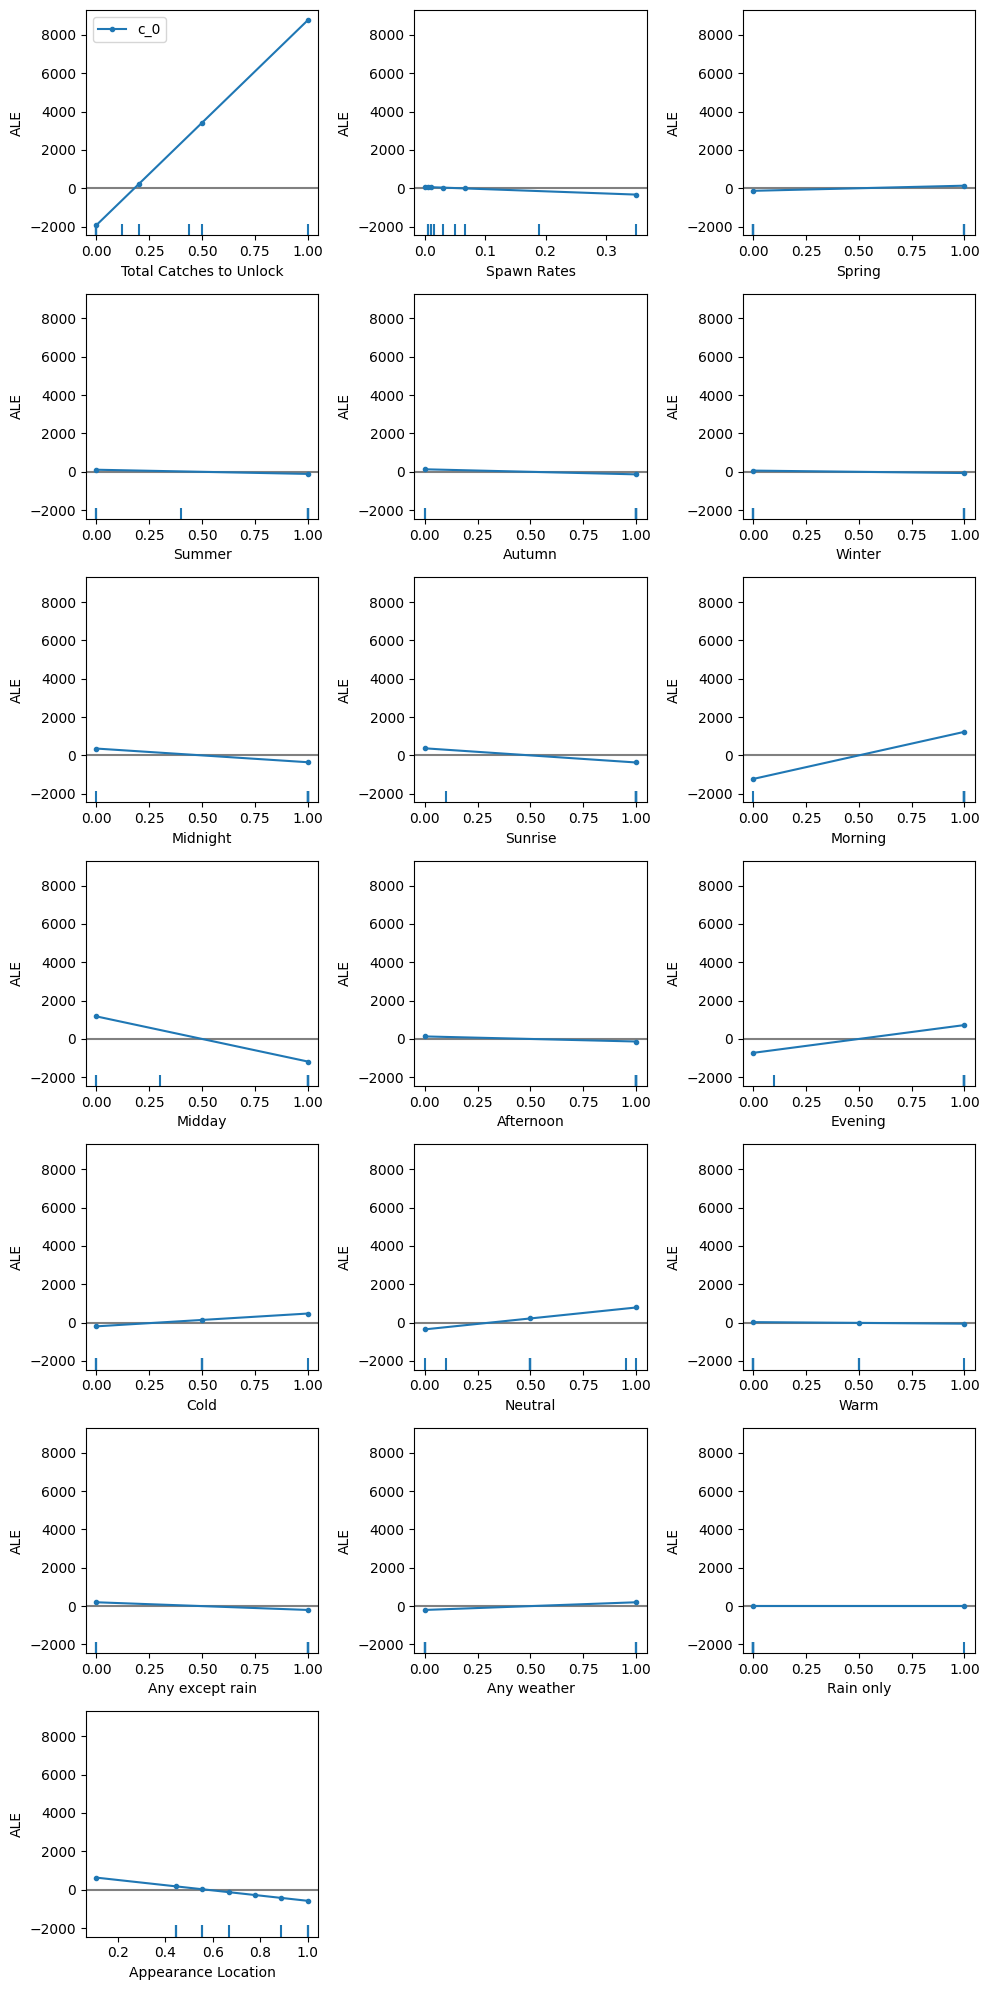

In [95]:
ln = LinearRegression()
ln.compute(dataframe)

# Creamos el predictor compatible
predictor = lambda x: ln._model.predict(pd.DataFrame(x, columns=ln._test_data.columns))

# Creamos el explicador ALE
ale = ALE(predictor=predictor, feature_names=ln._test_data.columns.tolist())

# Explicamos usando el test set, convertido a NumPy array
exp = ale.explain(ln._test_data.to_numpy())

# Definimos el tamaño de cada celda de salida
fig, ax = plt.subplots(figsize=(10,20))
# Pasamos el eje a la función
plot_ale(exp, ax=ax)
# Mostramos el resultado
plt.show()

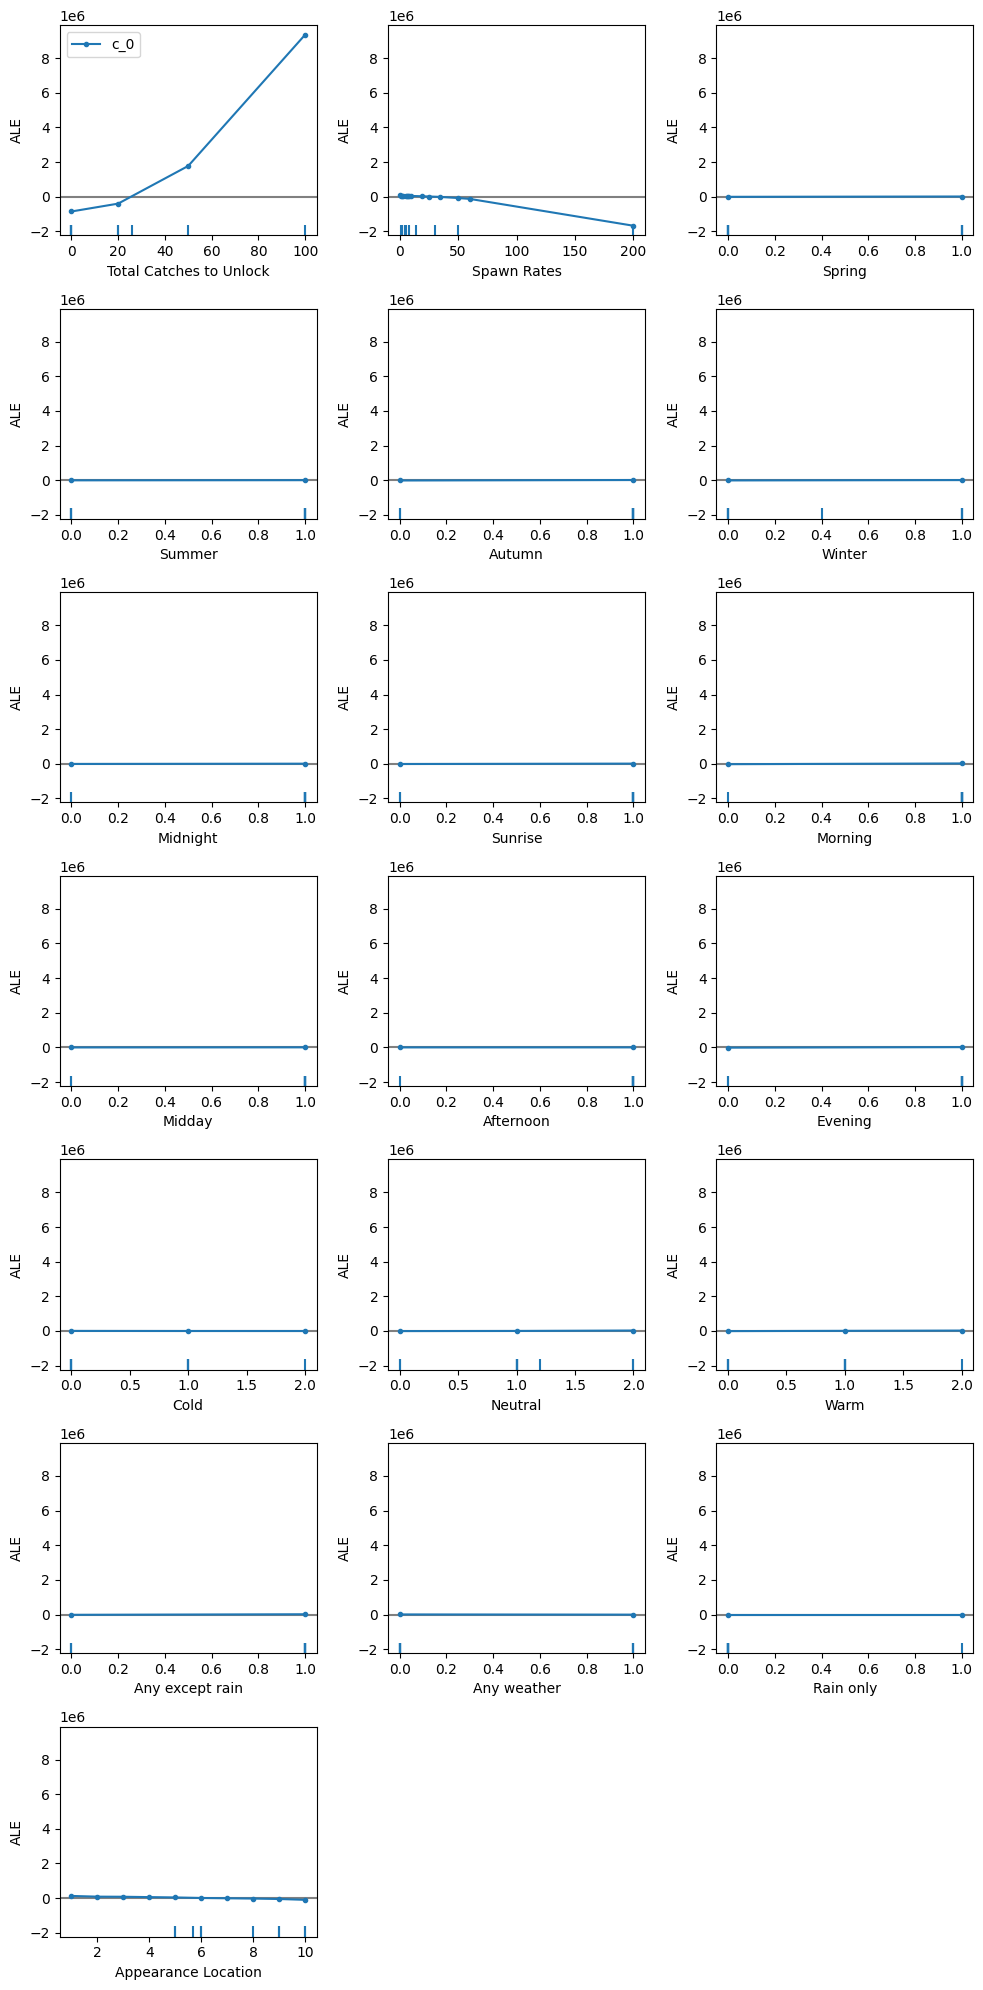

In [96]:
# Ejemplo de uso con PolynomialRegression
pr = PolynomialRegression(degree=2)
pr.compute(dataframe)

# Obtenemos los nombres de las columnas originales (sin 'Sell')
original_columns = [col for col in pr._data.columns if col != 'Sell']

# Creamos el predictor compatible con Alibi
def predictor(x):
    # Convertimos a DataFrame manteniendo los nombres de las columnas
    x_df = pd.DataFrame(x, columns=original_columns)
    # Aplicamos la transformación polinómica
    x_poly = pr._poly_features.transform(x_df)
    # Hacemos la predicción
    return pr._model.predict(x_poly)

# Creamos el explicador ALE
ale = ALE(predictor=predictor, feature_names=original_columns)

# Explicamos usando los datos originales (asegurando que son numéricos)
exp = ale.explain(X_original.to_numpy())

# Mostramos el resultado
fig, ax = plt.subplots(figsize=(10,20))  # Ancho x Alto en pulgadas
plot_ale(exp, ax=ax)  # Pasas el eje a la función
plt.show()

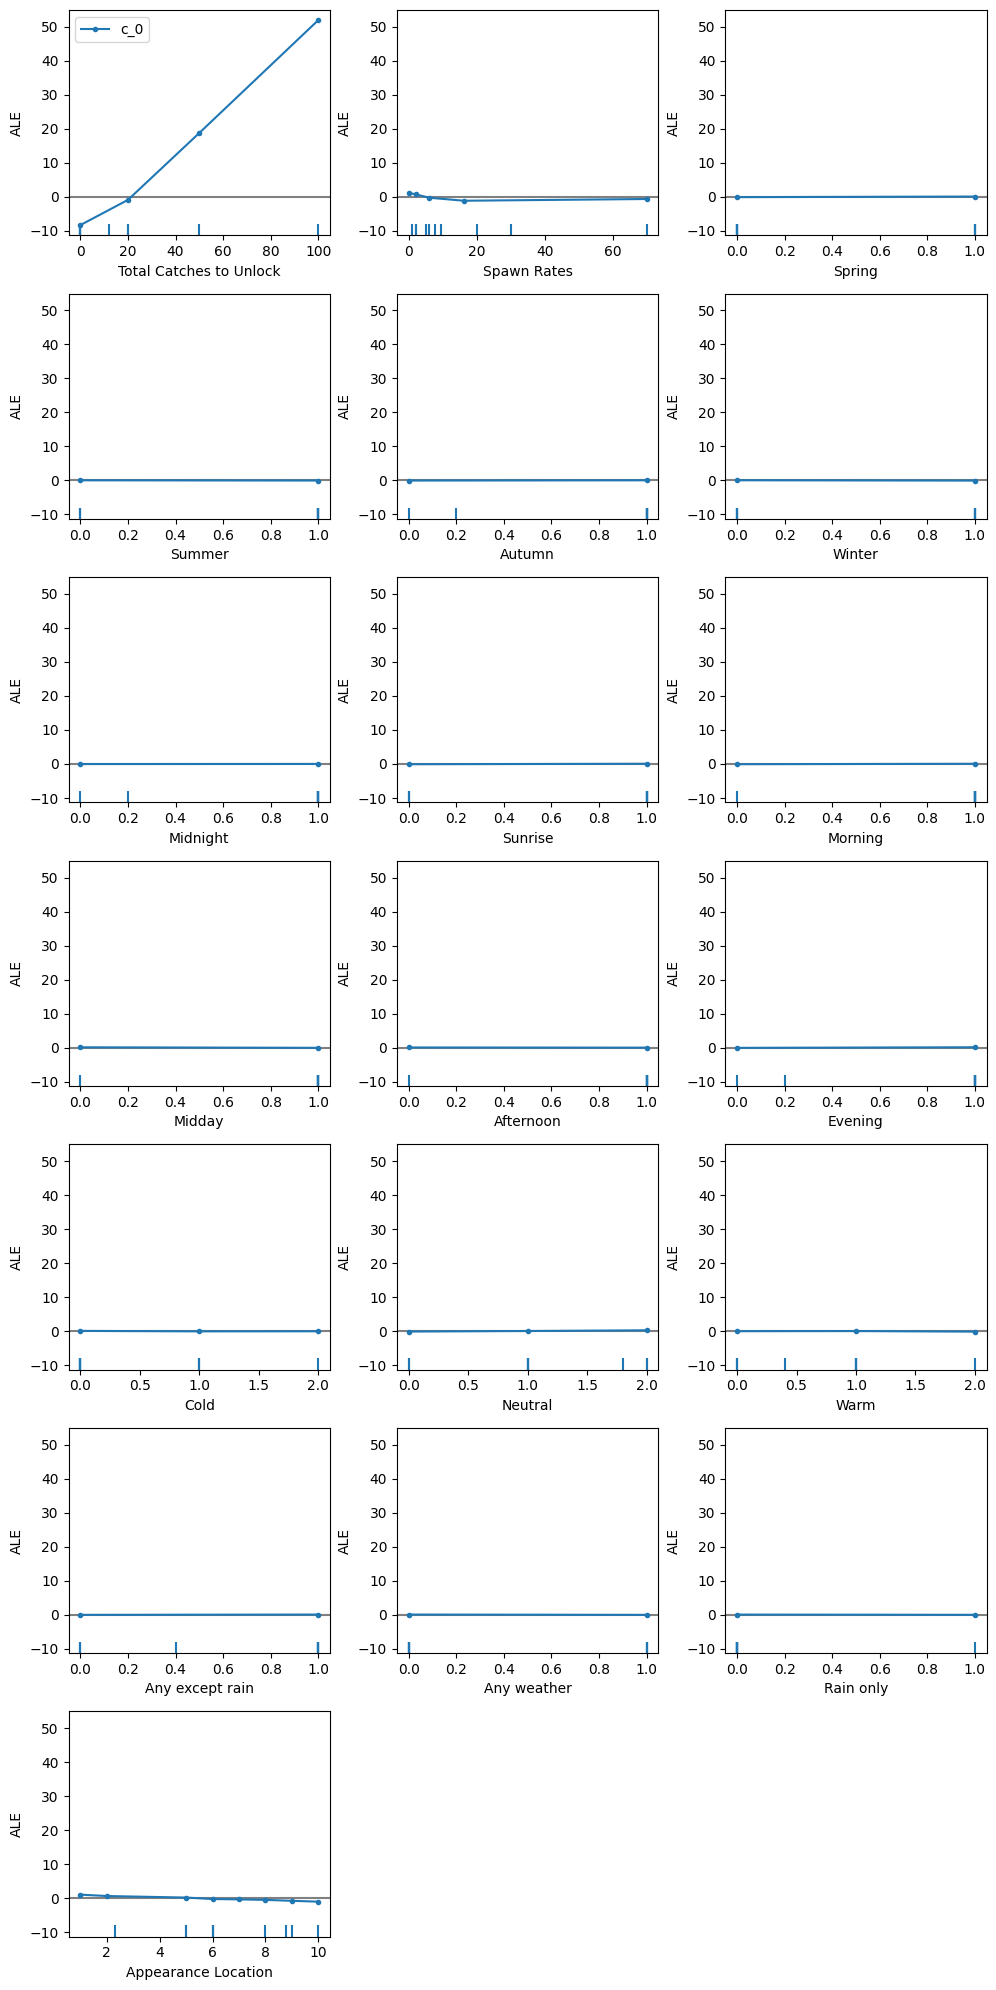

In [105]:
# 1. Crear y entrenar el modelo
model = FeedforwardNeuralNetModel(
    df=dataframe,
    using_relu=True,
    dropout=0.1
)
model.fit(show_info=False)

# 2. Función predictora directa
def predictor(x):
    x_tensor = torch.FloatTensor(x)
    model.eval()
    with torch.no_grad():
        return model(x_tensor).numpy()

# 3.
columnas = [col for col in dataframe.columns if col != "Sell"]

# Ponemos un tamaño de sample del 20%
sample_size = int(len(dataframe) * 0.2)
# Y obtenemos los datos
sample_data = dataframe[columnas].sample(sample_size, random_state=42)

# Convertimos a un formato adecuado para pytorch: numpy array de float32
X_sample = sample_data.values.astype(np.float32)

# Creamos el ALE
ale = ALE(
    predictor=predictor,
    feature_names=columnas,
)
# Pedimos la explicación
exp = ale.explain(X_sample)

# Mostramos resultados
fig, ax = plt.subplots(figsize=(10, 20))
plot_ale(exp, ax=ax)
plt.show()

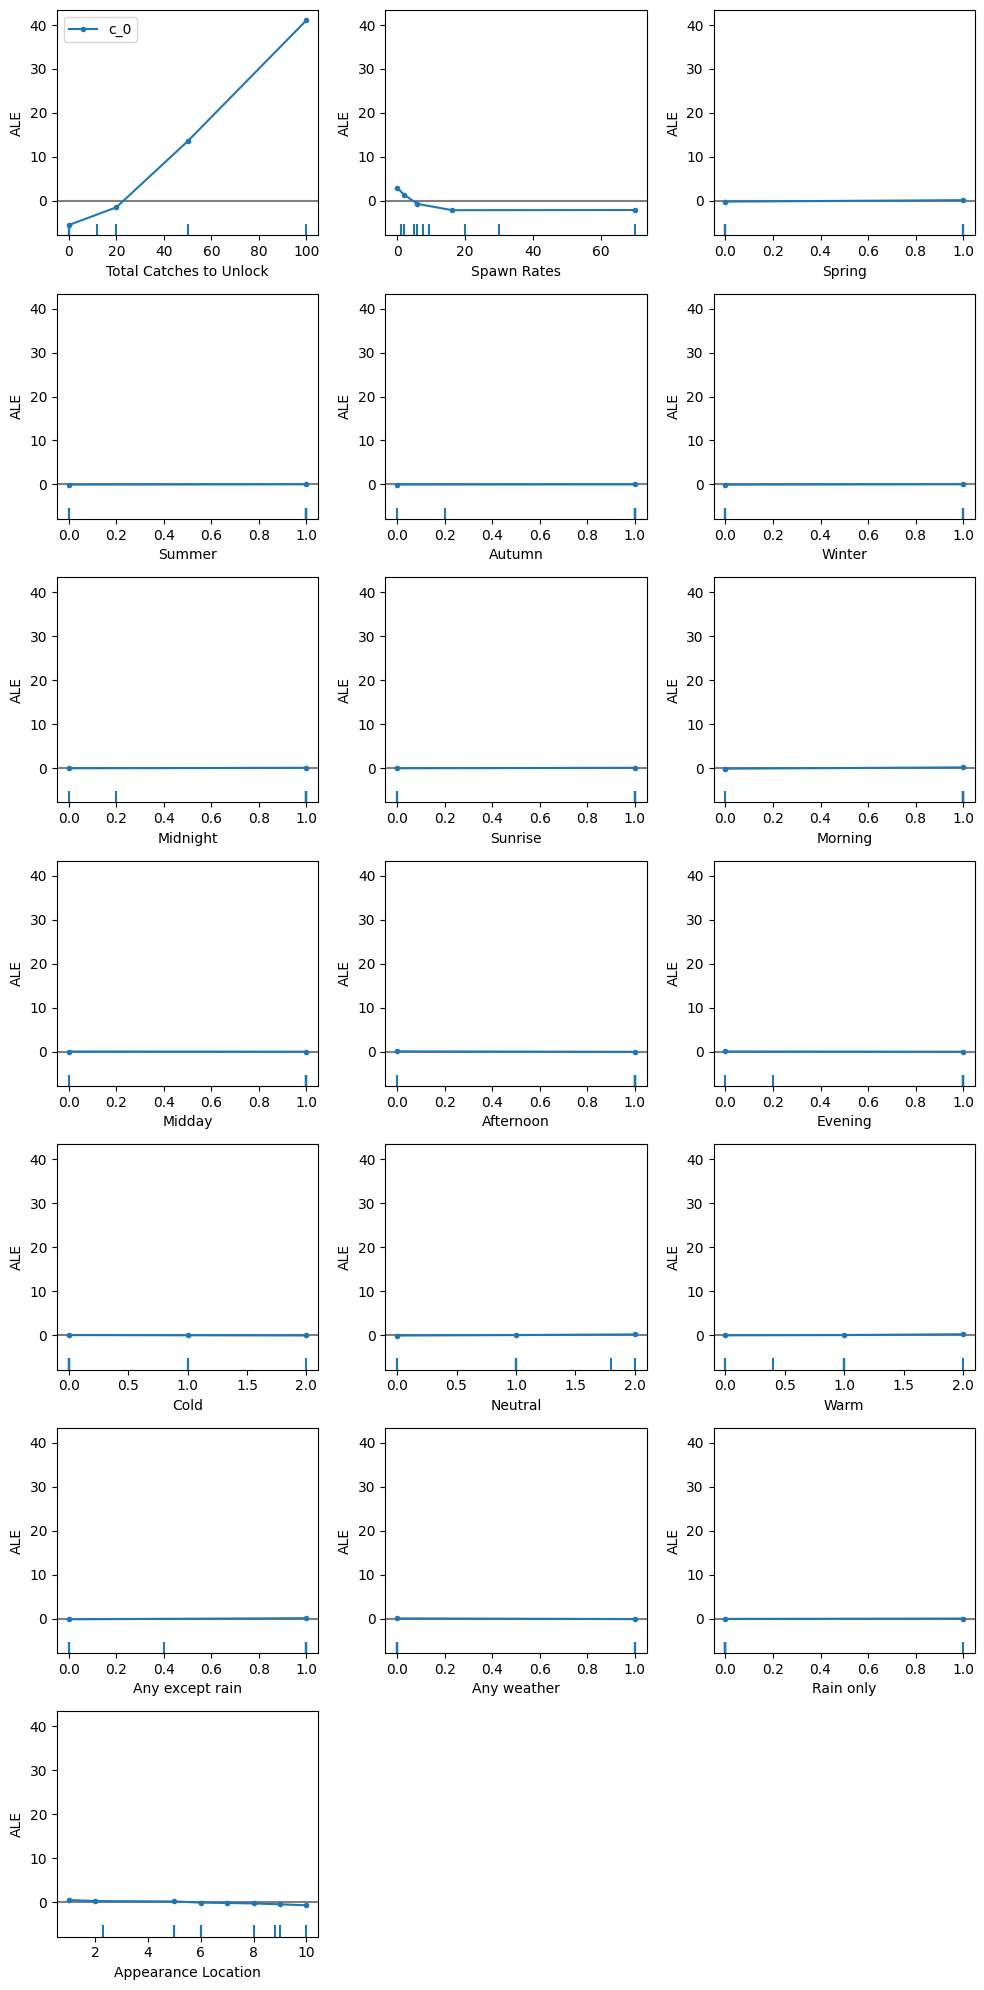

In [112]:
# 1. Crear y entrenar el modelo
model = FeedforwardNeuralNetModel(
    df=dataframe,
    using_relu=True,
    dropout=0.1
)
model.fit(show_info=False)

# 2. Función predictora simplificada
def predictor(x):
    # Convertir a tensor (sin escalar)
    x_tensor = torch.FloatTensor(x)

    # Poner modelo en modo evaluación
    model.eval()

    # Hacer predicciones
    with torch.no_grad():
        predictions = model(x_tensor).numpy()

    # Ensure output is 2D (samples × outputs)
    if predictions.ndim == 1:
        predictions = predictions.reshape(-1, 1)
    return predictions

# 3.
columnas = [col for col in dataframe.columns if col != "Sell"]

# Ponemos un tamaño de sample del 20%
sample_size = int(len(dataframe) * 0.2)
# Y obtenemos los datos
sample_data = dataframe[columnas].sample(sample_size, random_state=42)

# Convertimos a un formato adecuado para pytorch: numpy array de float32
X_sample = sample_data.values.astype(np.float32)

# Creamos el ALE
ale = ALE(
    predictor=predictor,
    feature_names=columnas,
)
# Pedimos la explicación
exp = ale.explain(X_sample)

# Mostramos resultados
fig, ax = plt.subplots(figsize=(10, 20))
plot_ale(exp, ax=ax)
plt.show()

LIME

[0 '0' 1 1 1 1 1 1 1 1 1 1 0 2 0 0 1 0 9]
Error al generar explicación: must be real number, not str

Posibles soluciones:
1. Asegúrate que todas las columnas son numéricas
2. Verifica que la muestra tenga el mismo formato que los datos de entrenamiento
3. Comprueba que el modelo está correctamente entrenado


/home/megastacks13/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
